In [1]:
from k1lib.imports import *

In [2]:
class Network(nn.Module):
    def __init__(self, hiddenDim=10, hiddenLayers=2, relu=True):
        super().__init__()
        activation = lambda: nn.LeakyReLU() if relu else nn.Sigmoid()
        layers = []
        layers += [nn.Linear(1, hiddenDim), activation()]
        for i in range(hiddenLayers):
            layers += [nn.Linear(hiddenDim, hiddenDim), activation()]
        layers += [nn.Linear(hiddenDim, 1)]
        self.bulk = nn.Sequential(*layers)
    def forward(self, x):
        return self.bulk(x)

In [3]:
def newL(lr=3e-3, momentum=0.9, bs=64):
    l = k1lib.Learner()
    l.model = Network(hiddenLayers=2)
    l.data = k1lib.data.Data.fromDataset(k1lib.data.FunctionDataset.exp, bs)
    l.opt = optim.SGD(l.model.parameters(), lr=lr, momentum=momentum)
    l.lossF = lambda x, y: ((x.squeeze() - y)**2).mean()
    #l.lossF = lambda x, y: (x**2).mean()
    l.cbs.withModifyBatch(lambda x, y: (x[:, None], y))
    l.cbs.withDType(torch.float32);
    def evaluate(self):
        xbs, ybs, ys = self.record(1, 3)
        xbs = torch.vstack(xbs).squeeze()
        ybs = torch.vstack([yb[:, None] for yb in ybs]).squeeze()
        ys = torch.vstack(ys).squeeze()
        #plt.plot(xbs, ybs, ".")
        plt.plot(xbs, ys.detach(), ".")
    l.evaluate = partial(evaluate, l)
    #l.cbs.append(k1lib.Callback().withCheckpoint("endBatch", lambda self: k1lib.raiseEx(k1lib.CancelRunException)))
    return l

In [4]:
momentums = np.linspace(0, 1.1, 10000)
progresses = []
for i, momentum in enumerate(momentums):
    l = newL(momentum=momentum)
    l.remove("Autosave")
    l.run(10)
    progresses.append(l.progress)
with open("autosave.pth", "wb") as f:
    pickle.dump(k1lib.Object.fromDict({"momentums": momentums, "progresses": progresses}), f)

Progress:  37%, epoch: 3/10, batch:  88/126, elapsed:   1.52s  Run cancelled: Explosion detected!.
Progress:  45%, epoch: 4/10, batch:  61/126, elapsed:   1.92s  Run cancelled: Explosion detected!.
Progress:  26%, epoch: 2/10, batch:  75/126, elapsed:   1.09s  Run cancelled: Explosion detected!.
Progress:   1%, epoch: 0/10, batch:   9/126, elapsed:   0.03s  Run cancelled: Explosion detected!.
Run cancelled: Explosion detected!.
Progress:  69%, epoch: 6/10, batch: 117/126, elapsed:   2.93s  Run cancelled: Explosion detected!.
Progress:  57%, epoch: 5/10, batch:  84/126, elapsed:   2.38s  Run cancelled: Explosion detected!.
Progress:  33%, epoch: 3/10, batch:  38/126, elapsed:    1.4s  Run cancelled: Explosion detected!.
Progress:   3%, epoch: 0/10, batch:  39/126, elapsed:   0.11s  Run cancelled: Explosion detected!.
Progress:   3%, epoch: 0/10, batch:  39/126, elapsed:   0.11s  Run cancelled: Explosion detected!.
Progress:   5%, epoch: 0/10, batch:  59/126, elapsed:   0.17s  Run cancel

## Analysis

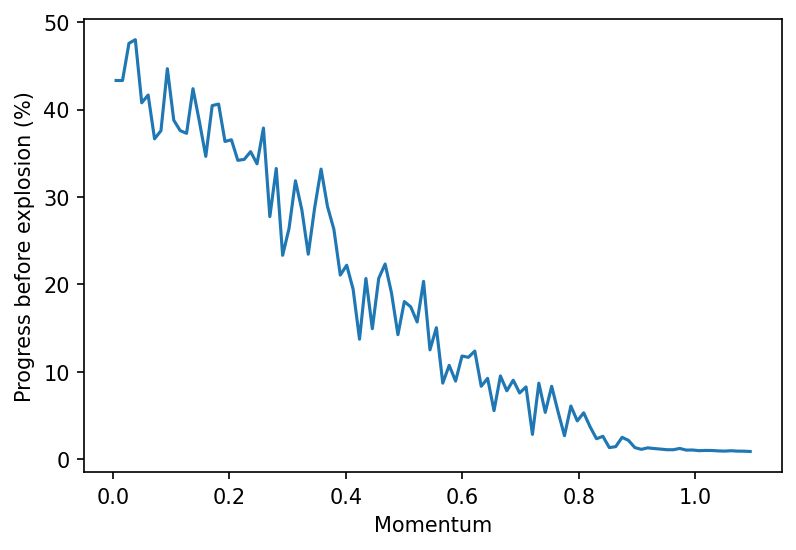

In [10]:
with open("data-big.pth", "rb") as f: data = pickle.load(f)
b = np.array(k1lib.smooth(data.progresses, 100))*100
a = k1lib.smooth(data.momentums, len(b))
plt.figure(dpi=150); plt.plot(a, b)
plt.xlabel("Momentum"); plt.ylabel("Progress before explosion (%)");

So, means that the momentum DOES drive the network to insane places, if not used correctly